In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

import h5py

from read3daedt import readaedt
import pandas as pd


import numpy as np
from PIL import Image

def convert_slices_to_image(slice_data_list):
    """
    将多个插值切片数据 (R, G, B 通道) 转换为 RGBA 图像。
    - NaN 值转换为透明像素 (0, 0, 0, 0)。
    - 每个切片映射到 R, G, B 通道，值被截断到 0-255 范围。

    参数：
    - slice_data_list: 长度为 3 的列表，每个元素是 2D numpy 数组，分别对应 R, G, B 通道。

    返回：
    - image: PIL 图像对象 (RGBA 格式)。
    """
    if len(slice_data_list) != 3:
        raise ValueError("slice_data_list 必须包含 3 个 2D 数组（分别对应 R, G, B 通道）。")

    # 获取切片的形状，假定所有通道形状相同
    height, width = slice_data_list[0].shape

    # 创建 RGBA 图像数组，初始化为 (0, 0, 0, 0)
    image_array = np.zeros((height, width, 4), dtype=np.uint8)

    # 遍历 R, G, B 通道，处理每个切片
    for channel, slice_data in enumerate(slice_data_list[:3]):
        # 对数据取绝对值
        abs_slice_data = np.abs(slice_data)

        # 找到有效数据（非 NaN 的索引）
        valid_mask = ~np.isnan(abs_slice_data)

        # 对有效数据进行归一化并截断到 0-255 范围
        normalized_data = np.clip(abs_slice_data[valid_mask], 0, 255).astype(np.uint8)

        # 设置对应的通道
        image_array[valid_mask, channel] = normalized_data
        
    # 设置 Alpha 通道为 255（不透明），仅对所有通道有效的像素设置
    valid_combined_mask = ~np.isnan(slice_data_list[0]) & ~np.isnan(slice_data_list[1]) & ~np.isnan(slice_data_list[2])
    image_array[valid_combined_mask, 3] = 255

    # 将结果转换为 PIL 图像
    image = Image.fromarray(image_array, mode="RGBA")

    return image

# 示例使用：
# 假设 slice_data_r, slice_data_g, slice_data_b 是你的插值数据
# image = convert_slices_to_image([slice_data_r, slice_data_g, slice_data_b])
# image.save("output_image_rgb.png")  # 保存为 PNG 图像


In [41]:

aedt_file = '../data/loop/LOOP E MOVE FEED=4mm_my=47mm.aedtplt'


aedt_file = '../data/loop/LOOP E MOVE FEED=34mm_my=-73mm.aedtplt'

with open(aedt_file, 'r', encoding='utf-8') as file:
    content = file.read()
    
image_root = aedt_file.split('/')[-1].split('.')[0]

x_data, y_data, z_data, field_values_list, points = readaedt(content)

points = np.array(points)

x_min = np.min(points[:, 0])
x_max = np.max(points[:, 0])
y_min = np.min(points[:, 1])
y_max = np.max(points[:, 1])
z_min = np.min(points[:, 2])
z_max = np.max(points[:, 2])

print("Y, X, Z range:", y_max - y_min, x_max - x_min, z_max - z_min)

print("Y:", y_min, y_max)
print("X:", x_min, x_max)
print("Z:", z_min, z_max)

print(len(field_values_list))





195477
Elements Size 15.0
Element Number 43597 [    4     3     3     3    10   819 19372  1080 19370 19399   821 18645
 18647 18646   765]
Max 65159


KeyboardInterrupt: 

In [52]:
# Y_grid = 512
# X_grid = (x_max - x_min) * Y_grid / (y_max - y_min)
# Z_grid = (z_max - z_min) * Y_grid / (y_max - y_min)



x_min = -100
x_max = 100
y_min = -200
y_max = 200
z_min = 3
z_max = 5


Y_grid = 801
X_grid = 401
Z_grid = 3

values = np.array(field_values_list[-1])
print("point number", len(points), "value number", len(values))

# 定义我们希望插值的规则网格范围
# 生成规则的网格坐标
# grid_x, grid_y, grid_z = np.mgrid[0:7:50j, 0:7:50j, 0:5:50j]
grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:X_grid * 1j, y_min:y_max:Y_grid * 1j, z_min:z_max:Z_grid * 1j]

# grid_values = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

grid_values_list = [griddata(points, values, (grid_x, grid_y, grid_z), method='linear') for values in field_values_list[:3]]

grid_values = grid_values_list[0]

point number 43597 value number 43597


In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

def save_image(image_file, slice_data, max_value = 400):
    # 定义分段颜色映射（0为中间点）
    colors = ["blue", "white", "red"]
    n_bins = 256  # 色阶数量
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

    # 创建分段的归一化器（以 0 为中点）
    norm = TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)

    # 绘制图像
    plt.figure(figsize=(8, 6))  # 可调整图像大小
    plt.imshow(slice_data, cmap=cmap, norm=norm, origin='lower')
    plt.colorbar(label="Dimension 0 Values")
    plt.title("Slice at Z mid (Dimension 0)")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    # 保存图像并关闭
    plt.savefig(image_file, dpi=300, bbox_inches='tight')  # dpi 控制分辨率
    plt.close()

    print(f"Image saved to {image_file}")

# 查看 grid_values_4d 的第一个维度
# slice_data = grid_values_4d[:, :, grid_values_4d.shape[2] // 2, 0]  # Z 轴中间，维度 0 的数据



In [69]:
sar_aedt = '../data/loop/LOOP SAR MOVE FEED=7mm_my=-13mm.aedtplt'


with open(sar_aedt, 'r', encoding='utf-8') as file:
    content = file.read()

x_data, y_data, z_data, field_values_list, points = readaedt(content)

points = np.array(points)

x_min = np.min(points[:, 0])
x_max = np.max(points[:, 0])
y_min = np.min(points[:, 1])
y_max = np.max(points[:, 1])
z_min = np.min(points[:, 2])
z_max = np.max(points[:, 2])

print(x_min, x_max, y_min, y_max, z_min, z_max)

160344
Elements Size 15.0
Element Number 35390 [    4     3     3     3    10   750 15774   673 10656 10655   285 10710
 10709 10654   289]
Max 53448
element 10.0 353903 35390.3
Each Element has 10 value
35390 [0.00025409 0.00026766 0.00028734 0.00014187 0.00025113 0.00011766
 0.00024313 0.0002518  0.00022581 0.00022433]
-119.70129973531866 119.8456780643476 -219.5324565132958 219.07765122015994 2.2216722946304057 24.137621877378116


11
point number 35390 value number 35390
cost time 6.14084005355835


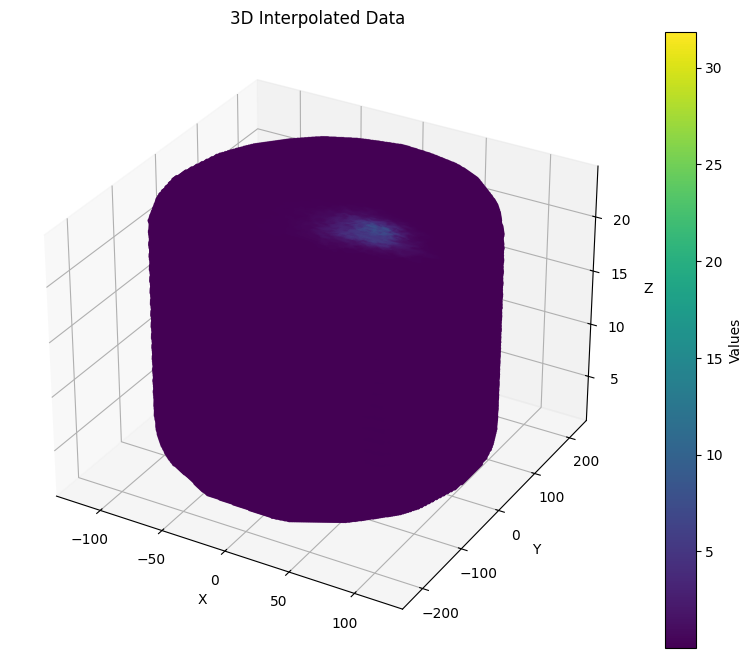

3.945586709978154e-05 31.83231702014566 ./temp_data/interpolation_sar_3.png
./temp_data/interpolation_sar_3_value_0_31.83231702014566.png


In [70]:
print(len(field_values_list))

# x_min = -100
# x_max = 100
# y_min = -200
# y_max = 200
# z_min = 2
# z_max = 24

Y_grid = int(y_max - y_min + 1)
X_grid = int(x_max - x_min + 1)
Z_grid = int((z_max - z_min)  + 1)

values = np.array(field_values_list[-1])
print("point number", len(points), "value number", len(values))

# 定义我们希望插值的规则网格范围
# 生成规则的网格坐标
grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:X_grid * 1j, y_min:y_max:Y_grid * 1j, z_min:z_max:Z_grid * 1j]


import time
begin_time = time.time()


grid_values_list = [griddata(points, values, (grid_x, grid_y, grid_z), method='linear') for values in field_values_list[:1]]

grid_values = grid_values_list[0]


end_time = time.time()

print("cost time", end_time - begin_time)


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 将三维网格和插值数据展开
x = grid_x.flatten()
y = grid_y.flatten()
z = grid_z.flatten()
values = grid_values.flatten()

# 绘制散点图
sc = ax.scatter(x, y, z, c=values, cmap='viridis', marker='o', s=2)
plt.colorbar(sc, ax=ax, label='Values')
ax.set_title("3D Interpolated Data")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
    

for j, grid_values in enumerate(grid_values_list):
    # 过滤掉 NaN 再计算最大最小值
    
    slice_data = grid_values[:, :, 3]

    # 过滤掉 NaN 值
    filtered_slice_data = slice_data[~np.isnan(slice_data)]
        
    image_file = f'./temp_data/interpolation_sar_{3}.png'
    # print(np.min(slice_data), np.max(slice_data), image_file)
    
    if filtered_slice_data.size > 0:
        min_value = np.min(filtered_slice_data)
        max_value = np.max(filtered_slice_data)
        print(min_value, max_value, image_file)
    else:
        print("当前切片数据全部为 NaN！", image_file)
        
    image_file = f'./temp_data/interpolation_sar_{3}_value_{j}_{max_value}.png'

    # 可以选择可视化某个切片来查看插值结果
    plt.imshow(slice_data, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis')
    plt.colorbar(label='Interpolated values')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Interpolated slice at Z = {i}')
    plt.savefig(image_file)
    plt.close()
    print(image_file)





## 循环读入电流文件 保留三个维度



正在处理 DIPOLE E MOVE FEED=10mm_my=62mm.aedtplt
197022
Elements Size 15.0
Element Number 44086 [    4     3     3     3    10   591 16489   640 15627 15628   527 15346
 15347 15343   508]
Max 65674
element 30.0 1322583 44086.1
Each Element has 30 value
44086 [-0.62402521  0.31693948 -0.25418503  0.15141142 -0.10732425 -0.02260723
  0.69522191 -0.42965937  0.12017658 -0.79012078  0.65871375 -0.26509739
 -0.10307345  0.22869742  0.05003455 -0.81255435  0.92601378 -0.11957813
 -0.80360118  0.37650334  0.05001494 -0.12599445  0.09580056  0.254132
 -0.92081732  0.64058632  0.1436748  -1.01939125  0.37518667  0.34502591]
数据已成功存储到 dipole_e_move_feed=10mm_my=62mm_zip.h5 文件中
Image saved to image_dipole/dipole_e_move_feed=10mm_my=62mm_slice_0.png
正在处理 DIPOLE E MOVE FEED=10mm_my=-13mm.aedtplt
201123
Elements Size 15.0
Element Number 44799 [    4     3     3     3    10   264 10716   131  9939  9938    54  9526
  9524  9523    13]
Max 67041
element 30.0 1343973 44799.1
Each Element has 30 value
44799

## 循环读入SAR 文件 只保留一个维度

In [87]:


import os
dir = '../data/loop/'
output_dir = "processed/"
image_dir = 'image_loop/'

dir = '../data/dipole/'
output_dir = "processed_dipole/"
image_dir = 'image_dipole/'


dir = '../data/slot/'
output_dir = "processed_slot/"
image_dir = 'image_slot/'


# dir = '../data/dipole/'
# output_dir = "processed_dipole/"
# image_dir = 'image_dipole/'



os.makedirs(output_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

sure_prefix = 'LOOP E MOVE'

sure_prefix = 'LOOP E MOVE'

for file in os.listdir(dir):
    if file.endswith('.aedtplt') and file.startswith(sure_prefix):
        print('正在处理', file)
        with open(os.path.join(dir, file), 'r', encoding='utf-8') as f:
            content = f.read()
            image_root = file.split('.')[0].lower().replace(' ', '_')
            x_data, y_data, z_data, field_values_list, points = readaedt(content)
            points = np.array(points)
            
            x_min = -100
            x_max = 100
            y_min = -200
            y_max = 200
            z_min = 3
            z_max = 5

            Y_grid = y_max - y_min + 1
            X_grid = x_max - x_min + 1
            Z_grid = (z_max - z_min) * 2 + 1

            values = np.array(field_values_list[-1])
            # print("point number", len(points), "value number", len(values))

            # 定义我们希望插值的规则网格范围
            # 生成规则的网格坐标
            grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:X_grid * 1j, y_min:y_max:Y_grid * 1j, z_min:z_max:Z_grid * 1j]

            grid_values_list = [griddata(points, values, (grid_x, grid_y, grid_z), method='linear') for values in field_values_list[:3]]
            grid_values_4d = np.stack(grid_values_list, axis=-1)  # 在最后一维堆叠

            # 存储到 HDF5 文件中
            with h5py.File(f"{output_dir}{image_root}_zip.h5", "w") as f:
                f.create_dataset("grid_values_4d", data=grid_values_4d, compression="gzip")
                
            print(f"数据已成功存储到 {f"{image_root}_zip.h5"} 文件中")

            slice_data = grid_values_4d[:, :, grid_values_4d.shape[2] // 2, 0]  # Z 轴中间，维度 0 的数据
            
            save_image(os.path.join(image_dir, f"{image_root}_slice_0.png"), slice_data)


sure_prefix = 'LOOP SAR MOVE'

for file in os.listdir(dir):
    if file.endswith('.aedtplt') and file.startswith(sure_prefix):
        print('正在处理', file)
        with open(os.path.join(dir, file), 'r', encoding='utf-8') as f:
            content = f.read()
            image_root = file.split('.')[0].lower().replace(' ', '_')
            x_data, y_data, z_data, field_values_list, points = readaedt(content)
            points = np.array(points)
            
            x_min = -100
            x_max = 100
            y_min = -200
            y_max = 200
            z_min = 3
            z_max = 5

            Y_grid = y_max - y_min + 1
            X_grid = x_max - x_min + 1
            Z_grid = (z_max - z_min) * 2 + 1

            values = np.array(field_values_list[-1])
            print("point number", len(points), "value number", len(values))

            # 定义我们希望插值的规则网格范围
            # 生成规则的网格坐标
            grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:X_grid * 1j, y_min:y_max:Y_grid * 1j, z_min:z_max:Z_grid * 1j]

            grid_values_list = [griddata(points, values, (grid_x, grid_y, grid_z), method='linear') for values in field_values_list[:1]]
            grid_values_4d = np.stack(grid_values_list, axis=-1)  # 在最后一维堆叠

            # 存储到 HDF5 文件中
            with h5py.File(f"{output_dir}{image_root}_zip.h5", "w") as f:
                f.create_dataset("grid_values_4d", data=grid_values_4d, compression="gzip")
                
            print(f"数据已成功存储到 {f"{image_root}_zip.h5"} 文件中")

            slice_data = grid_values_4d[:, :, grid_values_4d.shape[2] // 2, 0]  # Z 轴中间，维度 0 的数据
            
            save_image(os.path.join(image_dir, f"{image_root}_slice_0.png"), slice_data, max_value = 50)



In [21]:

image_dir = "temp"
with open("./temp/DIPOLE withoutbodyE MOVE FEED=1mm_my=-73mm.aedtplt", 'r', encoding='utf-8') as f:
    content = f.read()
    
image_root = file.split('.')[0].lower().replace(' ', '_')
x_data, y_data, z_data, field_values_list, points = readaedt(content)
points = np.array(points)

x_min = -100
x_max = 100
y_min = -200
y_max = 200
z_min = 3
z_max = 5

x_min = min(x_data)
x_max = max(x_data)
y_min = min(y_data)
y_max = max(y_data)
z_min = min(z_data)
z_max = max(z_data)


print(x_min, x_max, y_min, y_max, z_min, z_max)

Y_grid = y_max - y_min + 1
X_grid = x_max - x_min + 1
Z_grid = (z_max - z_min) * 2 + 1

values = np.array(field_values_list[-1])
# print("point number", len(points), "value number", len(values))

# 定义我们希望插值的规则网格范围
# 生成规则的网格坐标
grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:X_grid * 1j, y_min:y_max:Y_grid * 1j, z_min:z_max:Z_grid * 1j]

grid_values_list = [griddata(points, values, (grid_x, grid_y, grid_z), method='linear') for values in field_values_list[:3]]
grid_values_4d = np.stack(grid_values_list, axis=-1)  # 在最后一维堆叠

# # 存储到 HDF5 文件中
# with h5py.File(f"{output_dir}{image_root}_zip.h5", "w") as f:
#     f.create_dataset("grid_values_4d", data=grid_values_4d, compression="gzip")
    
# print(f"数据已成功存储到 {f"{image_root}_zip.h5"} 文件中")

grid_values_4d

slice_data = grid_values_4d[:, :, grid_values_4d.shape[2] // 2, 0]  # Z 轴中间，维度 0 的数据

slice_data = np.nan_to_num(slice_data, nan = 0)

print("max", slice_data.max(), slice_data.min())



save_image(os.path.join(image_dir, f"{image_root}_slice_0.png"), slice_data, max_value = 400)


-111.07500239423896 109.8873512005163 -219.40629903750005 219.4062990375 2.4793847148818413 22.201569681624555
max 154.06718587636985 -421.43182703693066
Image saved to temp/loop_sar_move_feed=7mm_my=17mm_slice_0.png


## 处理 current

In [6]:

import os
# dir = '../data/loop/'
# output_dir = "processed/"
# image_dir = 'image_loop/'

# dir = '../data/dipole/'
# output_dir = "processed_dipole/"
# image_dir = 'image_dipole/'

dir = '../data/dipole/'
output_dir = "processed_dipole_current/"
image_dir = 'image_dipole_current/'

dir = '../data/loop/'
output_dir = "processed_loop_current/"
image_dir = 'image_loop_current/'


os.makedirs(output_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)


import h5py
import numpy as np
from PIL import Image

def current_h5_to_rgb_png(h5_file_path, output_png_path, data_key="grid_values_4d", value_range=(-100, 100)):
    """
    将 HDF5 文件中的三维数据转化为 RGB PNG 图像。

    Parameters:
        h5_file_path (str): 输入的 HDF5 文件路径。
        output_png_path (str): 输出 PNG 文件路径。
        data_key (str): HDF5 文件中数据集的键名，默认 "grid_values_4d"。
        value_range (tuple): 数据归一化的范围，默认 (-100, 100)。

    Returns:
        None
    """
    # 打开 HDF5 文件
    with h5py.File(h5_file_path, "r") as f:
        data = f[data_key][:]
    
    # 检查数据维度是否匹配
    if data.shape[-1] < 3:
        raise ValueError("数据的最后一维必须大于等于 3，以映射到 RGB 通道。")
    
    
    data = data[:, :, :3]  # 只取前三个维度作为 RGB 通道
    
    data = np.nan_to_num(data, nan=0.0)
    # 提取范围
    min_val, max_val = value_range
    
    # 数据归一化到 [0, 1]
    normalized_data = (data - min_val) / (max_val - min_val)
    normalized_data = np.clip(normalized_data, 0, 1)  # 限制范围在 [0, 1]
    
    # 转化为 [0, 255] 的 RGB 值
    rgb_data = (normalized_data * 255).astype(np.uint8)
    
    # 创建 RGB 图像
    rgb_image = Image.fromarray(rgb_data, mode="RGB")
    
    # 保存为 PNG 文件
    rgb_image.save(output_png_path)
    print(f"RGB 图像已保存到: {output_png_path}")




for file in os.listdir(dir):
    if file.endswith('.aedtplt') and file.startswith('LOOP CURRENT MOVE'):
        with open(os.path.join(dir, file), 'r', encoding='utf-8') as f:
            content = f.read()
            
        image_root = file.split('.')[0].lower().replace(' ', '_')
        x_data, y_data, z_data, field_values_list, points = readaedt(content)
        points = np.array(points)

        z_min = np.min(points[:, 2])
        z_max = np.max(points[:, 2])
        
        x_min = -40
        x_max = 40
        y_min = -75
        y_max = 75
        

        print("X", x_min, x_max)
        print("Y", y_min, y_max)
        print("Z", z_min, z_max)

        # 提取坐标
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]

        # 筛选满足 |z| < 0.1 的点的索引
        indices = [i for i, zi in enumerate(z) if abs(zi) < 0.1]

        # 获取对应的 x, y
        filtered_x = [x[i] for i in indices]
        filtered_y = [y[i] for i in indices]

        width = 512
        height = 512

        # 定义网格范围
        grid_x, grid_y = np.meshgrid(
            np.linspace(x_min, x_max, width),
            np.linspace(y_min, y_max, height)
        )

        # 插值计算
        grid_values_4d = np.zeros((width, height, 3))  # 存储插值后的 4D 数据

        for i, field_values in enumerate(field_values_list[:3]):
            # 提取满足条件的场值
            filtered_field_values = [field_values[idx] for idx in indices]
            
            # 插值
            grid_z = griddata(
                points=(filtered_x, filtered_y),
                values=filtered_field_values,
                xi=(grid_x, grid_y),
                method='cubic'
            )
            
            # 存储结果
            grid_values_4d[:, :, i] = grid_z
            
        
        zip_file = os.path.join(output_dir, f"{image_root}_zip.h5")

        # os.remove(zip_file)
        image_file = os.path.join(image_dir, f"{image_root}.png")
        
        with h5py.File(zip_file, "w") as f:
            f.create_dataset("grid_values_4d", data=grid_values_4d, compression="gzip")
            print(f"HDF5 文件保存成功：{zip_file}")
        
        current_h5_to_rgb_png(zip_file, image_file)
        


X -40 40
Y -75 75
Z -5.000000000000001 3.355485758010128e-15
HDF5 文件保存成功：processed_loop_current/loop_current_move_feed=1mm_my=2mm_zip.h5
RGB 图像已保存到: image_loop_current/loop_current_move_feed=1mm_my=2mm.png
X -40 40
Y -75 75
Z -5.000000000000004 4.158331409986889e-15
HDF5 文件保存成功：processed_loop_current/loop_current_move_feed=19mm_my=-58mm_zip.h5
RGB 图像已保存到: image_loop_current/loop_current_move_feed=19mm_my=-58mm.png
X -40 40
Y -75 75
Z -5.000000000000002 3.950196206234221e-15
HDF5 文件保存成功：processed_loop_current/loop_current_move_feed=13mm_my=-43mm_zip.h5
RGB 图像已保存到: image_loop_current/loop_current_move_feed=13mm_my=-43mm.png
X -40 40
Y -75 75
Z -5.000000000000001 3.713185313926826e-15
HDF5 文件保存成功：processed_loop_current/loop_current_move_feed=1mm_my=32mm_zip.h5
RGB 图像已保存到: image_loop_current/loop_current_move_feed=1mm_my=32mm.png
X -40 40
Y -75 75
Z -4.000000000000006 2.615853346836307e-15
HDF5 文件保存成功：processed_loop_current/loop_current_move_feed=19mm_my=2mm_zip.h5
RGB 图像已保存到: image_loop_c

In [9]:
import os
import shutil

# 定义源文件夹和目标文件夹
source_folder = 'image_dipole_current'
target_folder = 'train_image/current'

if os.path.exists(target_folder):
    shutil.rmtree(target_folder)
os.makedirs(target_folder, exist_ok=True)

types = ['dipole', 'loop', 'slot']

# 遍历源文件夹中的所有文件
for tianxian_type in types:
    source_folder = f"image_{tianxian_type}_current"
    for filename in os.listdir(source_folder):
        # 构造源文件和目标文件的完整路径
        if not filename.endswith('.png'):
            continue
        source_file = os.path.join(source_folder, filename)
        renamed_file = '_'.join(filename.split('_')[3:])
        target_file = os.path.join(target_folder, f'{tianxian_type}_{renamed_file}')
        # 复制文件
        shutil.copy(source_file, target_file)

print("文件复制并重命名完成。")


文件复制并重命名完成。


In [10]:
import os
from PIL import Image

def combine_images(train_image_dir):
    """
    将 train_image 目录下 `current` 和 `input` 中具有相同文件名的图片拼接并保存到 combine 文件夹中。
    
    - 将 `input` 中的图片拉伸到 512x512。
    - 拼接时 `current` 图片在左，`input` 图片在右，最终图片为 1024x512。
    - 合并后的图片保存到 combine 文件夹。

    Parameters:
        train_image_dir (str): train_image 目录路径。
    """
    # 定义文件夹路径
    current_dir = os.path.join(train_image_dir, "current")
    input_dir = os.path.join(train_image_dir, "input")
    combine_dir = os.path.join(train_image_dir, "combine")

    # 创建 combine 文件夹
    os.makedirs(combine_dir, exist_ok=True)

    # 获取 current 和 input 文件夹下的文件列表
    current_files = set(os.listdir(current_dir))
    input_files = set(os.listdir(input_dir))

    # 找到两者的交集（同名文件）
    common_files = current_files.intersection(input_files)

    for file_name in common_files:
        current_path = os.path.join(current_dir, file_name)
        input_path = os.path.join(input_dir, file_name)
        combine_path = os.path.join(combine_dir, file_name)

        try:
            # 打开图片
            current_img = Image.open(current_path)
            input_img = Image.open(input_path)

            # 将 input 图片拉伸为 512x512
            input_img = input_img.resize((512, 512))

            # 获取 current 图片大小
            current_img = current_img.resize((512, 512))

            # 创建 1024x512 的新图像
            combined_img = Image.new("RGB", (1024, 512))

            # 将 current 和 input 拼接到新图像中
            combined_img.paste(current_img, (0, 0))  # 左边
            combined_img.paste(input_img, (512, 0))  # 右边

            # 保存拼接后的图像
            combined_img.save(combine_path)
            print(f"已保存: {combine_path}")
        except Exception as e:
            print(f"处理 {file_name} 时出错: {e}")

# 调用函数
train_image_dir = "./train_image"  # 替换为你的 train_image 目录路径
combine_images(train_image_dir)


已保存: ./train_image/combine/loop_feed=10mm_my=-43mm.png
已保存: ./train_image/combine/loop_feed=19mm_my=-73mm.png
已保存: ./train_image/combine/loop_feed=31mm_my=62mm.png
已保存: ./train_image/combine/dipole_feed=34mm_my=-73mm.png
已保存: ./train_image/combine/dipole_feed=31mm_my=-28mm.png
已保存: ./train_image/combine/slot_feed=-20mm_my=2mm.png
已保存: ./train_image/combine/loop_feed=34mm_my=32mm.png
已保存: ./train_image/combine/loop_feed=13mm_my=-43mm.png
已保存: ./train_image/combine/loop_feed=22mm_my=17mm.png
已保存: ./train_image/combine/loop_feed=28mm_my=-43mm.png
已保存: ./train_image/combine/slot_feed=35mm_my=12mm.png
已保存: ./train_image/combine/loop_feed=25mm_my=-43mm.png
已保存: ./train_image/combine/dipole_feed=7mm_my=-28mm.png
已保存: ./train_image/combine/dipole_feed=19mm_my=32mm.png
已保存: ./train_image/combine/dipole_feed=25mm_my=-13mm.png
已保存: ./train_image/combine/loop_feed=10mm_my=2mm.png
已保存: ./train_image/combine/dipole_feed=4mm_my=-58mm.png
已保存: ./train_image/combine/dipole_feed=34mm_my=-28mm.png
已保存: .

In [35]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# 打开 HDF5 文件
file_path = "./interpolated_zip.h5"
with h5py.File(file_path, "r") as f:
    # 加载数据
    grid_values_4d = f["grid_values_4d"][:]
    print(f"数据形状: {grid_values_4d.shape}")
    
current_h5_to_rgb_png("./interpolated_zip.h5", "./interpolated_rgb233.png")

# # 默认值为 0 
# grid_values_4d = np.nan_to_num(grid_values_4d, nan=0.0)


# # 确认数据维度和形状
# x_dim, y_dim, field_dim = grid_values_4d.shape  # 获取各维度大小

# # 绘制每个场值的二维图像
# for i in range(field_dim):
#     print(f"Field Value Dimension {i} max = {grid_values_4d[:, :, i].max()} min = {grid_values_4d[:, :, i].min()}")
#     plt.figure(figsize=(8, 6))
#     plt.imshow(
#         grid_values_4d[:, :, i],
#         origin="lower",
#         cmap="viridis",
#         extent=(0, x_dim, 0, y_dim)
#     )
#     plt.colorbar(label=f"Field Value Dimension {i}")
#     plt.title(f"Interpolated Field Value (Dimension {i})")
#     plt.xlabel("Grid X")
#     plt.ylabel("Grid Y")
#     plt.grid(alpha=0.3)
#     plt.show()


数据形状: (512, 512, 19)
RGB 图像已保存到: ./interpolated_rgb233.png


## 读取 h5文件 处理成图片

In [22]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from PIL import Image


import h5py
import numpy as np
from PIL import Image

def process_and_save_image_with_centering(h5_file_path, output_image_path, min_val=-400, max_val=400):
    """
    处理 HDF5 文件中的四维网格数据，将其重心平移到中心后转换为 RGB 图像并保存。

    参数:
        h5_file_path (str): HDF5 文件路径。
        output_image_path (str): 输出图像文件路径。
        min_val (float): 数据归一化的最小值，默认 -400。
        max_val (float): 数据归一化的最大值，默认 400。
    """
    # 加载数据
    with h5py.File(h5_file_path, "r") as f:
        grid_values_4d = f["grid_values_4d"][:]

    # 替换 NaN 为 0
    grid_values_4d = np.nan_to_num(grid_values_4d, nan=0.0)

    # 计算绝对值重心
    abs_values = np.abs(grid_values_4d)
    total_mass = np.sum(abs_values)
    grid_shape = grid_values_4d.shape

    # 重心位置
    centroid = np.array([
        np.sum(abs_values * np.arange(grid_shape[0])[:, None, None, None]) / total_mass,
        np.sum(abs_values * np.arange(grid_shape[1])[None, :, None, None]) / total_mass,
        np.sum(abs_values * np.arange(grid_shape[2])[None, None, :, None]) / total_mass,
    ])

    # 目标中心点
    target_center = np.array(grid_shape[:3]) / 2

    # 平移量
    shift = target_center - centroid

    # 移动重心到中心，使用插值或直接平移并填充零
    centered_grid_values = np.zeros_like(grid_values_4d)
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            for k in range(grid_shape[2]):
                new_i = int(round(i + shift[0]))
                new_j = int(round(j + shift[1]))
                new_k = int(round(k + shift[2]))
                if 0 <= new_i < grid_shape[0] and 0 <= new_j < grid_shape[1] and 0 <= new_k < grid_shape[2]:
                    centered_grid_values[new_i, new_j, new_k, :] = grid_values_4d[i, j, k, :]

    # 重新归一化
    centered_grid_values = (centered_grid_values - min_val) / (max_val - min_val)
    centered_grid_values = np.clip(centered_grid_values, 0, 1)

    # 抽取第三维的中间层
    z_middle_index = centered_grid_values.shape[2] // 2
    image_2d = centered_grid_values[:, :, z_middle_index, :]

    # 如果第三维只有 1 个通道，复制三份变为 RGB
    if image_2d.shape[-1] == 1:
        image_2d = np.repeat(image_2d, 3, axis=-1)

    # 转换为 8 位 (0-255) 的整数类型
    image_2d_uint8 = (image_2d * 255).astype(np.uint8)

    # 使用 PIL 创建图像
    image = Image.fromarray(image_2d_uint8, mode="RGB")

    # 保存图像
    image.save(output_image_path)

    print(f"图像已保存到 {output_image_path}")
    print(f"初始重心: {centroid}, 平移量: {shift}")



def process_and_save_image(h5_file_path, output_image_path, min_val=-400, max_val=400):
    """
    处理 HDF5 文件中的四维网格数据，将其转换为 RGB 图像并保存。

    参数:
        h5_file_path (str): HDF5 文件路径。
        output_image_path (str): 输出图像文件路径。
        min_val (float): 数据归一化的最小值，默认 -400。
        max_val (float): 数据归一化的最大值，默认 400。
    """
    # 加载数据
    with h5py.File(h5_file_path, "r") as f:
        grid_values_4d = f["grid_values_4d"][:]

    # 替换 NaN 为 0
    grid_values_4d = np.nan_to_num(grid_values_4d, nan=0.0)

    # 将值归一化到 [0, 1]
    grid_values_4d = (grid_values_4d - min_val) / (max_val - min_val)
    grid_values_4d = np.clip(grid_values_4d, 0, 1)  # 防止超出范围

    # 抽取第三维的中间层
    z_middle_index = grid_values_4d.shape[2] // 2
    image_2d = grid_values_4d[:, :, z_middle_index, :]

    # 如果第三维只有 1 个通道，复制三份变为 RGB
    if image_2d.shape[-1] == 1:
        image_2d = np.repeat(image_2d, 3, axis=-1)

    # 转换为 8 位 (0-255) 的整数类型
    image_2d_uint8 = (image_2d * 255).astype(np.uint8)

    # 使用 PIL 创建图像
    image = Image.fromarray(image_2d_uint8, mode="RGB")

    # 保存图像
    image.save(output_image_path)

    print(f"图像已保存到 {output_image_path}")


# name_prefix = 'loop_'
# data_saved = "processed/"

name_prefix = 'dipole_'
data_saved = "processed_dipole/"

input_dir = "train_image/input/"
output_dir = "train_image/output/"

# os.removedirs(input_dir)
# os.removedirs(output_dir)
# os.system('rm -rf train_image')

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)





for file in os.listdir(data_saved):
    if file.startswith("dipole_e_move"):
        h5_file_path = os.path.join(data_saved, file)
        file_name = name_prefix + '_'.join(file.split('_')[3: -1]) + '.png'
        output_image_path = os.path.join(input_dir, file_name)
        process_and_save_image(h5_file_path=h5_file_path, output_image_path=output_image_path, min_val=-400, max_val=400)
    elif file.startswith("dipole_sar_move"):
        h5_file_path = os.path.join(data_saved, file)
        file_name = name_prefix + '_'.join(file.split('_')[3: -1]) + '.png'
        output_image_path = os.path.join(output_dir, file_name)
        process_and_save_image(h5_file_path=h5_file_path, output_image_path=output_image_path, min_val=0, max_val=50)

# 加载数据
with h5py.File("processed/loop_sar_move_feed=4mm_my=62mm_zip.h5", "r") as f:
    grid_values_4d = f["grid_values_4d"][:]


print(grid_values_4d.shape)

# # 可视化
# plt.imshow(image_2d)
# plt.axis("off")
# plt.title("Middle Layer Visualization")
# plt.show()


SyntaxError: expected argument value expression (800093242.py, line 143)

In [28]:
import h5py
import numpy as np
from PIL import Image

def process_and_save_image_with_xy_centering(h5_file_path, output_image_path, min_val=-400, max_val=400):
    """
    处理 HDF5 文件中的四维网格数据，将其在 x 和 y 方向的重心平移到中心后转换为 RGB 图像并保存。

    参数:
        h5_file_path (str): HDF5 文件路径。
        output_image_path (str): 输出图像文件路径。
        min_val (float): 数据归一化的最小值，默认 -400。
        max_val (float): 数据归一化的最大值，默认 400。
    """
    # 加载数据
    with h5py.File(h5_file_path, "r") as f:
        grid_values_4d = f["grid_values_4d"][:]

    # 替换 NaN 为 0
    grid_values_4d = np.nan_to_num(grid_values_4d, nan=0.0)

    # 计算绝对值重心
    abs_values = np.abs(grid_values_4d)
    total_mass = np.sum(abs_values)
    grid_shape = grid_values_4d.shape

    # 计算 x 和 y 的重心
    centroid_x = np.sum(abs_values * np.arange(grid_shape[0])[:, None, None, None]) / total_mass
    centroid_y = np.sum(abs_values * np.arange(grid_shape[1])[None, :, None, None]) / total_mass

    # 目标中心点
    target_center_x = grid_shape[0] / 2
    target_center_y = grid_shape[1] / 2

    # 平移量
    shift_x = target_center_x - centroid_x
    shift_y = target_center_y - centroid_y

    # 移动重心到中心，仅调整 x 和 y 方向
    centered_grid_values = np.zeros_like(grid_values_4d)
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            new_i = int(round(i + shift_x))
            new_j = int(round(j + shift_y))
            if 0 <= new_i < grid_shape[0] and 0 <= new_j < grid_shape[1]:
                centered_grid_values[new_i, new_j, :, :] = grid_values_4d[i, j, :, :]

    # 重新归一化
    centered_grid_values = (centered_grid_values - min_val) / (max_val - min_val)
    centered_grid_values = np.clip(centered_grid_values, 0, 1)

    # 抽取第三维的中间层
    z_middle_index = centered_grid_values.shape[2] // 2
    image_2d = centered_grid_values[:, :, z_middle_index, :]

    # 如果第三维只有 1 个通道，复制三份变为 RGB
    if image_2d.shape[-1] == 1:
        image_2d = np.repeat(image_2d, 3, axis=-1)

    # 转换为 8 位 (0-255) 的整数类型
    image_2d_uint8 = (image_2d * 255).astype(np.uint8)

    # 裁剪宽度到与高度相等的部分，以中心为基准
    height, width, _ = image_2d_uint8.shape
    if width > height:
        left = (width - height) // 2
        right = left + height
        image_2d_uint8 = image_2d_uint8[:, left:right, :]
    else:
        top = (height - width) // 2
        bottom = top + width
        image_2d_uint8 = image_2d_uint8[top:bottom, :, :]

    # 缩放到 512x512
    image = Image.fromarray(image_2d_uint8, mode="RGB")
    image = image.resize((512, 512))
    
    # 保存图像
    image.save(output_image_path)

    print(f"图像已保存到 {output_image_path}")
    print(f"x 重心: {centroid_x}, y 重心: {centroid_y}, 平移量: (x: {shift_x}, y: {shift_y})")


name_prefix = 'dipole_'
data_saved = "processed_dipole/"

input_dir = "train_image/centered_e/"
output_dir = "train_image/centered_sar/"

# os.removedirs(input_dir)
# os.removedirs(output_dir)
# os.system('rm -rf train_image')

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

for antenna_type in ['dipole', 'slot', 'loop']:
    data_saved = f"processed_{antenna_type}/"

    e_move_files = [f for f in os.listdir(data_saved) if "e_move" in f]
    sar_move_files = [f for f in os.listdir(data_saved) if "sar_move" in f]
    
    name_prefix = f"{antenna_type}_"

    for file in os.listdir(data_saved):
        if "_e_move_" in file:
            h5_file_path = os.path.join(data_saved, file)
            file_name = name_prefix + '_'.join(file.split('_')[3: -1]) + '.png'
            output_image_path = os.path.join(input_dir, file_name)
            process_and_save_image_with_xy_centering(h5_file_path=h5_file_path, output_image_path=output_image_path, min_val=-400, max_val=400)
        elif "_sar_move_" in file:
            h5_file_path = os.path.join(data_saved, file)
            file_name = name_prefix + '_'.join(file.split('_')[3: -1]) + '.png'
            output_image_path = os.path.join(output_dir, file_name)
            process_and_save_image_with_xy_centering(h5_file_path=h5_file_path, output_image_path=output_image_path, min_val=0, max_val=50)


# process_and_save_image_with_xy_centering("./processed_dipole/dipole_e_move_feed=1mm_my=2mm_zip.h5", output_image_path = "temp/test_centering.png")

图像已保存到 train_image/centered_sar/dipole_feed=16mm_my=-73mm.png
x 重心: 136.98297324708471, y 重心: 127.28772238615096, 平移量: (x: -36.482973247084715, y: 73.21227761384904)
图像已保存到 train_image/centered_sar/dipole_feed=1mm_my=-58mm.png
x 重心: 135.2831797939816, y 重心: 151.4212425376269, 平移量: (x: -34.78317979398159, y: 49.07875746237309)
图像已保存到 train_image/centered_e/dipole_feed=13mm_my=-28mm.png
x 重心: 118.94874265984176, y 重心: 180.3142474911049, 平移量: (x: -18.448742659841756, y: 20.185752508895092)
图像已保存到 train_image/centered_sar/dipole_feed=28mm_my=-58mm.png
x 重心: 137.36665886309672, y 重心: 141.84035598787355, 平移量: (x: -36.86665886309672, y: 58.65964401212645)
图像已保存到 train_image/centered_sar/dipole_feed=10mm_my=47mm.png
x 重心: 129.40912370792606, y 重心: 252.97715845591554, 平移量: (x: -28.909123707926057, y: -52.47715845591554)
图像已保存到 train_image/centered_e/dipole_feed=10mm_my=32mm.png
x 重心: 119.86397937760538, y 重心: 232.5690656514486, 平移量: (x: -19.363979377605375, y: -32.0690656514486)
图像已保存到 train_im

In [55]:
import numpy as np
import h5py

# 假设 grid_values_list 已经被创建
# grid_values_list = [griddata(points, values, (grid_x, grid_y, grid_z), method='linear') for values in field_values_list[:3]]

# 将 grid_values_list 转换为四维数组
grid_values_4d = np.stack(grid_values_list, axis=-1)  # 在最后一维堆叠

print("grid_values_4d shape:", grid_values_4d.shape)  # (X_grid, Y_grid, Z_grid, 3)

# 存储到 HDF5 文件中
with h5py.File("grid_values_4d_zip9.h5", "w") as f:
    f.create_dataset("grid_values_4d", data=grid_values_4d, compression="gzip")

print("数据已成功存储到 grid_values_4d.h5 文件中")


grid_values_4d shape: (401, 801, 3, 3)
数据已成功存储到 grid_values_4d.h5 文件中


Loaded grid_values_4d shape: (401, 801, 3, 3)


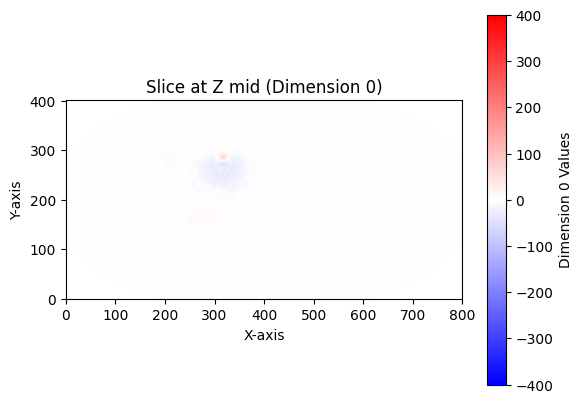

In [56]:
# 加载存储的数据
with h5py.File("grid_values_4d_zip9.h5", "r") as f:
    loaded_grid_values_4d = f["grid_values_4d"][:]
    print("Loaded grid_values_4d shape:", loaded_grid_values_4d.shape)





In [47]:
print(grid_values_list[0].shape)

print(grid_values[0][0][0])

for i in range(int(Z_grid)):
    
    slice_data_list = [grid_values_list[j][:, :, i] for j in range(len(grid_values_list))]
    # slice_data = grid_values[:, :, i]
    
    for slice_data in slice_data_list:
        filtered_slice_data = slice_data[~np.isnan(slice_data)]
        
        if filtered_slice_data.size > 0:
            min_value = np.min(filtered_slice_data)
            max_value = np.max(filtered_slice_data)
            print(min_value, max_value, f"{i}th layer")
        else:
            print("当前切片数据全部为 NaN！", f"{i}th layer")
        
    image_file = f"temp_data/{image_root}_slice_{i}.png"
    
    image_data = convert_slices_to_image(slice_data_list)
    image_data.save(image_file)


(401, 801, 6)
nan
-72.56304724993937 185.58422697737979 0th layer
-176.61996440880304 171.74591552468362 0th layer
-13.95861521156648 423.363247504068 0th layer
-54.585410995450324 133.44041828882987 1th layer
-141.42415507657856 126.42261388467682 1th layer
-14.539896460842918 297.17414302537196 1th layer
-49.21695199729019 105.33849290936266 2th layer
-94.42552750958757 92.8350683920527 2th layer
-15.121916040519803 223.9991213757812 2th layer
-49.04539542938289 86.79695159652613 3th layer
-74.19264239859515 64.15732103407802 3th layer
-15.413000599159247 186.9245906333729 3th layer
-50.57246687866967 67.0415561229576 4th layer
-59.35136024936068 59.50082028834983 4th layer
-15.933979051955019 170.15819373018186 4th layer
-52.78399816065435 51.26430164013549 5th layer
-51.454689956796805 53.54433185576922 5th layer
-16.2285113728603 141.23838036301413 5th layer


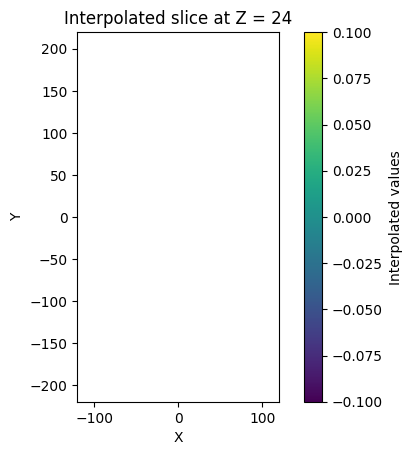

In [18]:
slice_data = grid_values[:, :, 0]
# 可以选择可视化某个切片来查看插值结果
plt.imshow(slice_data, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Interpolated slice at Z = {i}')
plt.show()
plt.close()

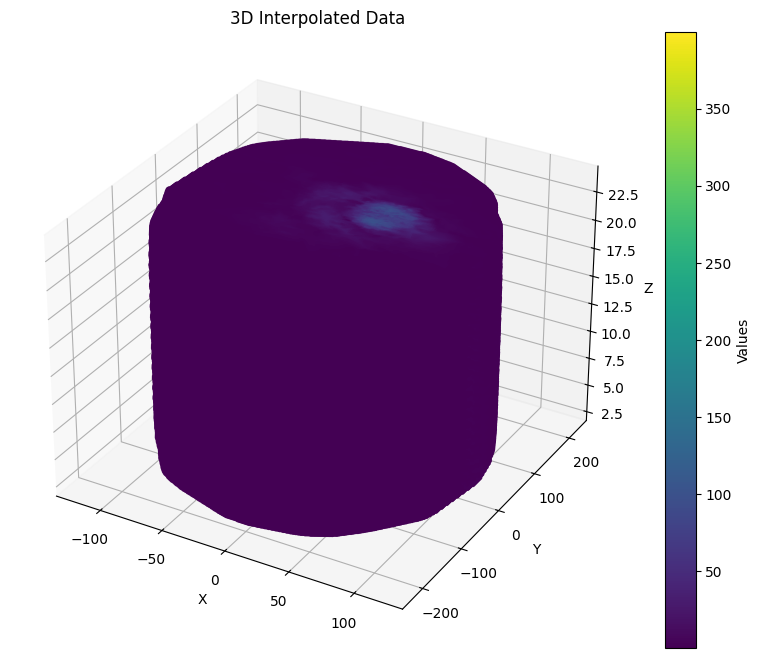

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 将三维网格和插值数据展开
x = grid_x.flatten()
y = grid_y.flatten()
z = grid_z.flatten()
values = grid_values.flatten()

# 绘制散点图
sc = ax.scatter(x, y, z, c=values, cmap='viridis', marker='o', s=2)
plt.colorbar(sc, ax=ax, label='Values')
ax.set_title("3D Interpolated Data")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()